In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

from Bio import SeqIO
from collections import Counter
import numpy as np

import glob,os

from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

typeface='Arial'
# mpl.rcParams['font.weight']=200
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

In [8]:
base_path='/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/'

seqs={}
seq_names={}

for aln_path in glob.glob(os.path.join(base_path,'*_aa.fasta')):
    print(aln_path)
    aln=SeqIO.parse(aln_path,format='fasta')
    aln_name=os.path.basename(aln_path).split('_')[0]
    
    seqs[aln_name]=[]
    seq_names[aln_name]=[]
    
    seq_names[os.path.basename(aln_path)]=[]
    for seq in aln:
        seq_names[aln_name].append(seq.id)
        seqs[aln_name].append(seq.seq)
        
    

/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/IAVgroup2_aa.fasta
/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/Alphas_aa.fasta
/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/Anellos_aa.fasta
/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/Gammas_aa.fasta
/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/HIV1_aa.fasta
/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/Betas_aa.fasta
/Users/carze/Documents/work/ring/projects/anellome_paper/data/recombination/data/AAV_capsid_aa.fasta


In [10]:
def entropy(column,alphabet_size=20):
    column=Counter(column)
    
    for invalid in ['-','X','*']:
        if invalid in column:
            column.pop(invalid)
    
    total=sum(column.values())
    
    entropy=0
    for x in column:
        entropy+=column[x]/total*np.log2(column[x]/total)/np.log2(alphabet_size)

    return -entropy

def unique_residues(column):
    column=Counter(column)
    
    for invalid in ['-','X','*']:
        if invalid in column:
            column.pop(invalid)
        
    return len(column)

count_valid=lambda k,cutoff: len(list(filter(lambda w: w not in ['X','-','*'],k)))>cutoff ## remove invalid residues from column, check if the number of remaining residues is above cut-off

ys={}

for aln in seqs:
    print(aln)
#     ys[aln]=[entropy(c) for c in zip(*seqs[aln]) if count_valid(c,len(c)*0.1)]
    ys[aln]=[unique_residues(c) for c in zip(*seqs[aln]) if count_valid(c,len(c)*0.1)] ## return number of unique residues at columns with at least 10% valid (non-gap, non-stop, non-ambiguous) residues

IAVgroup2
Alphas
Anellos
Gammas
HIV1
Betas
AAV


              Alphas 	mean: 11.142	st.dev.: 4.309
               Betas 	mean: 12.603	st.dev.: 4.475
              Gammas 	mean: 9.114	st.dev.: 4.518
                HIV1 	mean: 12.448	st.dev.: 4.325
           IAVgroup2 	mean: 6.312	st.dev.: 3.296
                 AAV 	mean: 3.804	st.dev.: 2.520


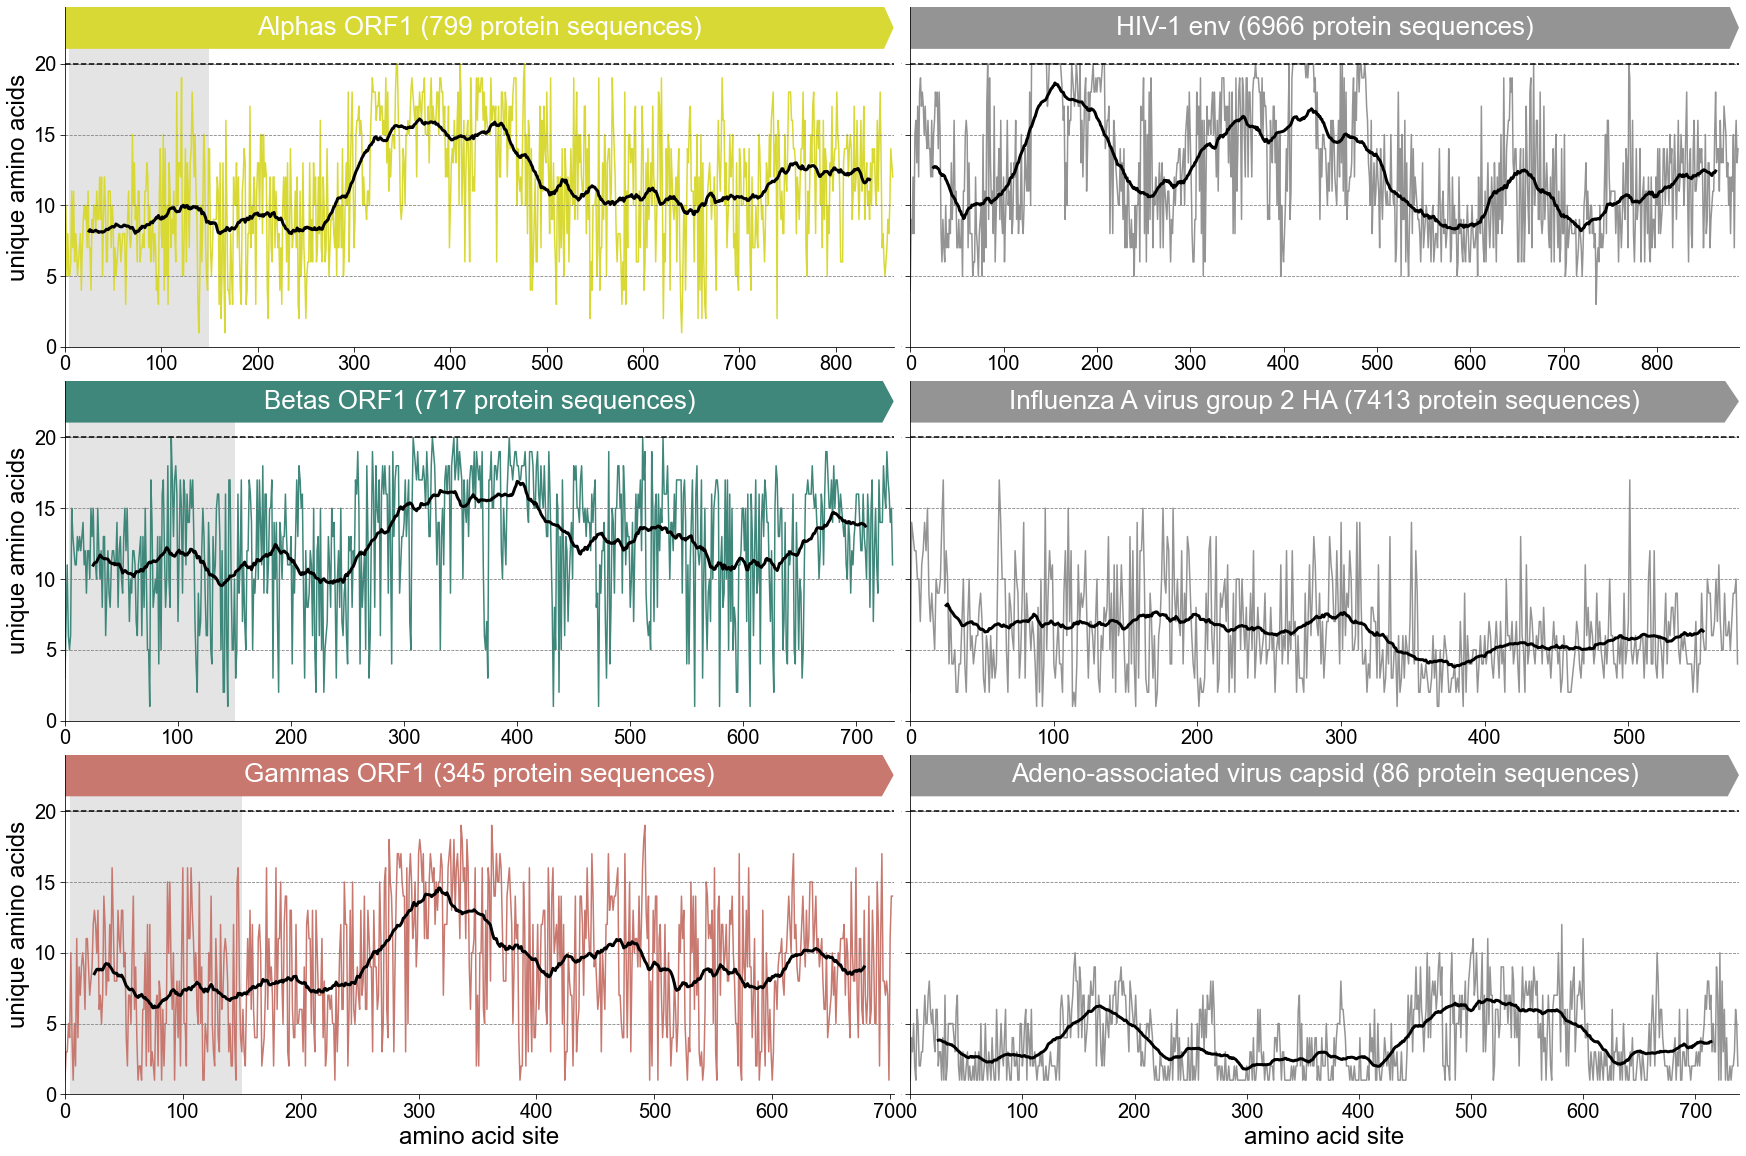

In [14]:
colours={'Betas': '#3F877A', 'Gammas': '#C8786F', 'Alphas': '#D9D936', 'Anellos': '#6F6B8D'}

rename={'IAVgroup2': 'Influenza A virus group 2','HIV1':'HIV-1','AAV':'Adeno-associated virus'}

genes={'Betas': 'ORF1', 'Gammas': 'ORF1', 'Alphas': 'ORF1', 'Anellos': 'ORF1', 
         'AAV': 'capsid', 'IAVgroup2': 'HA', 'HIV1': 'env'}


fig = plt.figure(figsize=(30, 20),facecolor='w') 
gs = gridspec.GridSpec(3,2,wspace=0.02,hspace=0.1) 


for a,aln in enumerate(['Alphas','Betas','Gammas','HIV1','IAVgroup2','AAV']): ## iterate over proteins
    row=a%3
    column=a//3
    
    ax=plt.subplot(gs[row,column],facecolor='w')
    
    w_size=50 ## window size for sliding window
    
    fc=colours[aln] if aln in colours else '#949494' ## Anello colour or grey
    
    ax.plot(range(len(ys[aln])),ys[aln],color=fc,zorder=1) ## plot raw data

    pys=list(map(np.mean,window(ys[aln],w_size))) ## mean sliding window across raw data
    
    ax.plot(range(int(w_size/2),int(len(pys)+w_size/2)),pys,lw=3,color='k',zorder=10) ## plot sliding window in black

    print('%20s \tmean: %.3f\tst.dev.: %.3f'%(aln,np.mean(ys[aln]),np.std(ys[aln])))
    
    w=3 ## width of arrow
    arrow_props={'head_length': 10,
                 'width': w,
                 'head_width': w, 
                 'length_includes_head': True, 
                 'edgecolor': 'none', 
                 'facecolor': fc} ## arrow parameters
    
    y=21.05
    ax.arrow(0,y+arrow_props['width']/2,len(ys[aln]),0,**arrow_props) ## arrow encompassing data range
    
    orf_name='%s %s (%d protein sequences)'%(rename[aln] if aln in rename else aln,genes[aln],len(seqs[aln])) ## format ORF name
    
    ax.text(len(ys[aln])/2,y+arrow_props['width']/2-0.01,orf_name,ha='center',va='center',color='w',size=26) ## add text in the middle
    
    if aln in ['Anellos','Alphas','Betas','Gammas']:
        ax.axvspan(4,150,facecolor='lightgrey',edgecolor='none',alpha=0.6,zorder=0) ## add grey box for anellos where the jelly-roll domain roughly is
    
    ax.set_ylim(0,24)
    ax.set_xlim(0,len(ys[aln])) ## plot bounds

    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom','left']] ## remove right and top spines
    
    ax.axhline(20.0,ls='--',color='k') ## max amino acid boundary
    ax.tick_params(size=5,labelsize=20)
    
    if column==0:
        ax.set_ylabel('unique amino acids',size=24) ## y-axis label for leftmost plots
    else:
        ax.tick_params(axis='y',size=5,labelsize=0)
        
    if row==2:
        ax.set_xlabel('amino acid site',size=24) ## x-axis label for bottom plots
        
    ax.grid(axis='y',ls='--',color='grey') ## y-axis grid
    
plt.show()

#plt.savefig(os.path.join(base_path, "orf_diversity_compare.pdf"))
fig.savefig(os.path.join(base_path, "orf_diversity_compare.pdf"))